### EXPERIMENT 3

#### 1. Using the Amazon, Google, Microsoft and Watson APIs obtain the sentiment
#### scores for your entire dataset.
#### 2. Normalize the scores and take the average normalized score to determine the sentiments
#### 3. Compute the confusion matrix wrt the original dataset and discuss your results.


In [225]:
import  urllib
import bs4
from bs4 import BeautifulSoup as bs
import os
import argparse
from urllib.request import Request, urlopen
import pandas as pd
from pandas import DataFrame as df
import json
import csv
import seaborn as sn
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

### FORMATTING JSON FILE TO GET THE DATA

In [76]:
data_1 = pd.read_json('NETFLIX_Q3_2018_EARNINGS_CALL_TRANSCRIPT_FANG.json')
data_1 = pd.DataFrame.sort_index(data_1)
split_para_1 = data_1.text
split_para_1 = list(split_para_1)


In [77]:
#data_2 = json.load(open('Amazon_Q3_2018_Earning_Call_Transcript_Sentiment_Manual.json'))
data_2 = pd.read_json('Amazon_Q3_2018_Earning_Call_Transcript_Sentiment_Manual.json')
data_2 = pd.DataFrame.sort_index(data_2)
split_para_2 = data_2.text
split_para_2 = list(split_para_2)
#data_2

In [85]:
data_3 = pd.read_json('FB_earnings_call_transcript.json')
data_3 = pd.DataFrame.sort_index(data_3)
split_para_3 = data_3.text
split_para_3 = list(split_para_3)

In [86]:
data_4 = pd.read_json('microsoft.json')
data_4 = pd.DataFrame.sort_index(data_4)
split_para_4 = data_4.text
split_para_4 = list(split_para_4)

In [87]:
data_5 = pd.read_json('google_call_earnings.json')
data_5 = pd.DataFrame.sort_index(data_5)
split_para_5 = data_5.paragraph
split_para_5 = list(split_para_5)
#data_5

In [89]:
split_para = split_para_1 + split_para_2 + split_para_3 + split_para_4 + split_para_5


### GOOGLE's CLOUD NATURAL PROCESSING API

In [537]:
#! pip install --upgrade requests google-cloud-language

In [538]:
#!pip install google-cloud 

In [90]:
import argparse
from google.cloud import language
from google.cloud.language import enums
from google.cloud.language import types
import os

In [91]:

client = language.LanguageServiceClient()
score =[]
for i in range(0,len(split_para)):
    text = split_para[i]
    document = types.Document(
        content=text,
    type=enums.Document.Type.PLAIN_TEXT)
    sentiment = client.analyze_sentiment(document=document).document_sentiment
    #sentiment = np.asarray(sentiment)
    score.append(sentiment.score)

In [92]:
google_df = pd.DataFrame(score,columns=['google_score'])

In [95]:
score_test = np.asarray(score)

In [96]:
for n,i in enumerate(score_test):
    if i < 0 :
        score_test[n] = -1
    elif i > 0:
        score_test[n] = 1
    else:
        score_test[n] = 0


In [97]:
normalized_google_score = pd.DataFrame(score_test,columns=['Normalized Score'])


In [98]:
normalized_google_df = google_df.join(normalized_google_score)

In [266]:
google_df.to_csv('google.csv')
normalized_google_df.head(10)

,google_score,Normalized Score
0,0.0,0.0
1,0.0,0.0
2,-0.2,-1.0
3,0.0,0.0
4,-0.1,-1.0
5,0.4,1.0
6,0.3,1.0
7,0.6,1.0
8,0.5,1.0
9,0.3,1.0


### AMAZON API

In [100]:
import boto3
import json

comprehend = boto3.client(service_name='comprehend', region_name='us-east-1',aws_access_key_id=access_key,
    aws_secret_access_key=secret_key)
 
print('Calling DetectSentiment')
    
score_aws = []
for i in range(0,len(split_para)):
    text = split_para[i]
    text = json.dumps(comprehend.detect_sentiment(Text=text, LanguageCode='en'), sort_keys=True, indent=4)
    score_aws.append(text)
        

#print(json.dumps(comprehend.detect_sentiment(Text=text, LanguageCode='en'), sort_keys=True, indent=4))
print('End of DetectSentiment\n')

Calling DetectSentiment
End of DetectSentiment



In [101]:
# to get the overall sentiment 

sentiment_score_aws=[]
for i in range(len(score_aws)):
    score = score_aws[i]
    score = str(score).replace('\n','')
    score = score.split('Sentiment')
    score = score[1]
    score = score[4:12]
    sentiment_score_aws.append(score)
    
aws_df = pd.DataFrame(sentiment_score_aws,columns=['aws_score'])

In [323]:
# getting all the scores, finding the maximum out of it and saving it

aws=[]

for i in range(len(score_aws)):
    z = str(score_aws[i]).replace('\n','').split('SentimentScore')[1]
    x = z.split(' ')
    a = x[10]
    b = x[19]
    c = x[28]
    d = x[37]
    a = str(a)
    a = a[0:10]
    b = str(b)
    b = b[0:10]
    c = str(c)
    c = c[0:10]
    d = str(d)
    d = d[0:10]
    a = max(a,b,c,d)
    aws.append(a)


In [329]:
aws = pd.DataFrame(aws,columns=['aws_score'])
aws.to_csv('aws.csv')

In [103]:
sentiment_score_aws_np = np.asarray(sentiment_score_aws)
for n, i in enumerate(sentiment_score_aws_np):
    if i == 'NEUTRAL"':
        sentiment_score_aws_np[n]= 0
    elif i == 'POSITIVE':
        sentiment_score_aws_np[n] = 1
    elif i == 'NEGATIVE':
        sentiment_score_aws_np[n] = -1
    else:
        sentiment_score_aws_np[n] = 0

normalized_aws_df = pd.DataFrame(sentiment_score_aws_np,columns=['Normalized aws score'])
normalized_aws_df = aws_df.join(normalized_aws_df)
#normalized_aws_df = aws_df.join(aws)
#normalized_aws_df.to_csv('normalized_aws.csv')
normalized_aws_df.head(10)

,aws_score,Normalized aws score
0,"NEUTRAL""",0
1,"NEUTRAL""",0
2,"NEUTRAL""",0
3,"NEUTRAL""",0
4,POSITIVE,1
5,"NEUTRAL""",0
6,NEGATIVE,-1
7,"NEUTRAL""",0
8,"NEUTRAL""",0
9,"NEUTRAL""",0


### WATSON API 

In [541]:
#!pip install watson-developer-cloud

In [104]:
from __future__ import print_function
import json
from watson_developer_cloud import NaturalLanguageUnderstandingV1
from watson_developer_cloud.natural_language_understanding_v1 import Features, SentimentOptions, KeywordsOptions


#If service instance provides API key authentication
service = NaturalLanguageUnderstandingV1(
     version='2018-03-16',
     url='https://gateway.watsonplatform.net/natural-language-understanding/api',
     iam_apikey=api)

score_watson =[]
for i in range(0,len(split_para)):
    text = split_para[i]
    response = service.analyze(text=text,features=Features(sentiment=SentimentOptions())).get_result()
    #sentiment = np.asarray(sentiment)
    score_watson.append(response)

In [379]:
wat = []
for i in range(len(score_watson)):
    temp = str(score_watson[i]).split('score')[1][3:7]
    if temp[1] == ',':
        temp = '0.0'
    else:
        temp = temp
    wat.append(temp)

In [380]:
wat = pd.DataFrame(wat,columns=['watson_score'])
wat.to_csv('watson.csv')
wat

,watson_score
0,0.0
1,0.77
2,0.71
3,0.0
4,0.76
5,0.47
6,0.63
7,0.0
8,0.60
9,0.79


In [105]:
sentiment_watson=[]
for i in range(len(score_watson)):
    text = str(score_watson[i]).split('label')
    text = text[1][4:11]
    sentiment_watson.append(text)
    
watson_df = pd.DataFrame(sentiment_watson,columns=['watson_score'])
watson_df

,watson_score
0,neutral
1,positiv
2,positiv
3,neutral
4,positiv
5,positiv
6,positiv
7,neutral
8,positiv
9,positiv


In [107]:
sentiment_score_watson_np = np.asarray(sentiment_watson)
for n, i in enumerate(sentiment_score_watson_np):
    if i == 'neutral':
        sentiment_score_watson_np[n]= 0
    if i == 'positiv':
        sentiment_score_watson_np[n] = 1
    elif i == 'negativ':
        sentiment_score_watson_np[n] = -1
    else:
        sentiment_score_watson_np[n] = 0

normalized_watson_df = pd.DataFrame(sentiment_score_watson_np,columns=['Normalized watson score'])
normalized_watson_df = watson_df.join(normalized_watson_df)
#normalized_watson_df.to_csv('normalized_watson.csv')
normalized_watson_df.head(10)

,watson_score,Normalized watson score
0,neutral,0
1,positiv,1
2,positiv,1
3,neutral,0
4,positiv,1
5,positiv,1
6,positiv,1
7,neutral,0
8,positiv,1
9,positiv,1


In [216]:
'''
sentiment_score_watson=[]
for i in range(len(score_watson)):
    score = score_watson[i]
    score = pd.DataFrame(score)
    score = score.emotion[0]
    score = pd.DataFrame(score)
    score = list(score.emotion)
    
    negative = (score[0]+score[1]+score[2]+score[4])/4
    positive = score[3]
    sentiments =(negative,positive)
    final_sentiment = max(sentiments)
    sentiment_score_watson.append(final_sentiment)

watson_df = pd.DataFrame(sentiment_score_watson,columns=['watson_score'])
watson_df
'''               

"\nsentiment_score_watson=[]\nfor i in range(len(score_watson)):\n    score = score_watson[i]\n    score = pd.DataFrame(score)\n    score = score.emotion[0]\n    score = pd.DataFrame(score)\n    score = list(score.emotion)\n    \n    negative = (score[0]+score[1]+score[2]+score[4])/4\n    positive = score[3]\n    sentiments =(negative,positive)\n    final_sentiment = max(sentiments)\n    sentiment_score_watson.append(final_sentiment)\n\nwatson_df = pd.DataFrame(sentiment_score_watson,columns=['watson_score'])\nwatson_df\n"

### AZURE API

In [108]:
import urllib.request
import urllib.response
import sys
import os, glob
import http.client, urllib
import json
import re

url = 'westcentralus.api.cognitive.microsoft.com'
path = '/text/analytics/v2.0/Sentiment'


In [109]:
documents = { 'documents': []}
count = 1
for i in range(0,len(split_para)):
    text = split_para[i]
    documents.setdefault('documents').append({"language":"en","id":str(count),"text":text})
    count+=1

In [131]:
def TextAnalytics(documents):
    headers = {'Ocp-Apim-Subscription-Key':key}
    conn = http.client.HTTPSConnection(url)
    body = json.dumps (documents)
    conn.request ("POST", path, body, headers)
    response = conn.getresponse ()
    return response.read ()

docs = documents
result = TextAnalytics (docs)
score_azure = (json.dumps(json.loads(result), indent=4))

In [132]:
score_azure = score_azure.replace('\n','')
score_azure = score_azure.split('id')

In [137]:
len(sentiment_score_azure[1:])

622

In [139]:
sentiment_score_azure=[]
for i in range(len(score_azure)-2):
    sentiment = score_azure[i][28:33]
    sentiment_score_azure.append(sentiment)


In [140]:
sentiment_score_azure = sentiment_score_azure[1:]
#q = str(sentiment_score_azure)
#q = q.split(',
ints =[]
for i in range(0,9):
    score = sentiment_score_azure[i]
    score = str(score)
    score = score[2]
    ints.append(score)
#q
#q = sentiment_score_azure[0]
#q = str(q)
for i in range(9,98):
    score = sentiment_score_azure[i]
    score = str(score)
    score = score[3]
    ints.append(score)

for i in range(98,622):
    score = sentiment_score_azure[i]
    score = str(score)
    score = score[4]
    ints.append(score)


In [268]:
azure_df = pd.DataFrame(sentiment_score_azure,columns=['azure_score'])
azure_df.to_csv('azure.csv')

In [142]:
sentiment_score_azure_np = np.asarray(ints)
#sentiment_score_azure_np = sentiment_score_azure_np.split(',')
for n, i in enumerate(sentiment_score_azure_np):
    if i == '5':
        sentiment_score_azure_np[n] = 0
    elif i > '5':
        sentiment_score_azure_np[n] = 1
    else  :
        sentiment_score_azure_np[n] = -1
    

normalized_azure_df = pd.DataFrame(sentiment_score_azure_np,columns=['Normalized azure score'])
normalized_azure_df = azure_df.join(normalized_azure_df)
normalized_azure_df = normalized_azure_df.replace('-','-1')
#normalized_azure_df.to_csv('normalized_azure.csv')
normalized_azure_df.head(10)

,azure_score,Normalized azure score
0,0.5,0
1,0.5,0
2,0.5,0
3,0.5,0
4,0.890,1
5,0.874,1
6,0.775,1
7,0.5,0
8,0.854,1
9,0.94,1


In [143]:
normalized_api_df = [normalized_aws_df,normalized_azure_df,normalized_watson_df]

In [144]:
normalized_api_df = normalized_google_df.join(normalized_api_df)

In [145]:
normalized_api_df

,google_score,Normalized Score,aws_score,Normalized aws score,azure_score,Normalized azure score,watson_score,Normalized watson score
0,0.0,0.0,"NEUTRAL""",0,0.5,0,neutral,0
1,0.0,0.0,"NEUTRAL""",0,0.5,0,positiv,1
2,-0.2,-1.0,"NEUTRAL""",0,0.5,0,positiv,1
3,0.0,0.0,"NEUTRAL""",0,0.5,0,neutral,0
4,-0.1,-1.0,POSITIVE,1,0.890,1,positiv,1
5,0.4,1.0,"NEUTRAL""",0,0.874,1,positiv,1
6,0.3,1.0,NEGATIVE,-1,0.775,1,positiv,1
7,0.6,1.0,"NEUTRAL""",0,0.5,0,neutral,0
8,0.5,1.0,"NEUTRAL""",0,0.854,1,positiv,1
9,0.3,1.0,"NEUTRAL""",0,0.94,1,positiv,1


In [146]:
normalized_df = normalized_api_df[['Normalized Score','Normalized aws score','Normalized azure score','Normalized watson score']]

In [147]:
normalized_df_median = normalized_df.median(axis=1)
normalized_df_median = pd.DataFrame(normalized_df_median,columns=['Highly Occuring Sentiment'])
normalized_df_median = normalized_df_median.replace(0.5,1)
normalized_df_median = normalized_df_median.replace(-0.5,-1)

predicted_sentis = normalized_df_median['Highly Occuring Sentiment'].values.tolist()

In [258]:
s = []
for i in range(len(predicted_sentis)):
    q = str(predicted_sentis[i])
    s.append(q)

,Highly Occuring Sentiment
0,0.0
1,0.0
2,0.0
3,0.0
4,1.0


### MANUAL SENTIMENTS FORMATTING 

In [259]:
senti_1 = list(data_1.Sentiments)

senti_2 = list(data_2.sentiment)

senti_3 = list(data_3.sentiment)

senti_4 = list(data_4.sentiment)

senti_5 = list(data_5.sentiment)

senti = senti_1 + senti_2 + senti_3 + senti_4 + senti_5

In [260]:
senti = np.asarray(senti)
for n, i in enumerate(senti):
    if i == 'Neutral':
        senti[n]= 0.0
    elif i == 'Positive':
        senti[n] = 1.0
    elif i == 'Negative':
        senti[n] = -1.0
    elif i == 'neutral' :
        senti[n]= 0.0
    elif i == 'positive':
        senti[n] = 1.0
    elif i == 'negative':
        senti[n] = -1.0
    else:
        senti[n] = 0.0


In [261]:
senti =list(senti)

### CONFUSION MATRIX

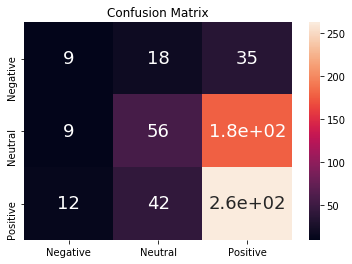

In [265]:
conmat = confusion_matrix(senti,s)
ax = plt.subplot()
ax.set_xlabel('Predicted Sentiments');ax.set_ylabel('Manual Sentiments'); 
ax.set_title('Confusion Matrix'); 
sn.heatmap(conmat, annot=True,annot_kws={"size": 18})# font size
ax.xaxis.set_ticklabels(['Negative','Neutral','Positive']); ax.yaxis.set_ticklabels(['Negative','Neutral','Positive']);
plt.show()

## PREDICTION ANALYSIS :
### CORRECT PREDICTION :
#### NEGATIVE - 9 out of 62 ; NEUTRAL - 56 out of 245 ; POSITIVE - 260 out of 314
### 1) NEGATIVE LABEL ANALYSIS :
#### 9 WERE PREDICTED AS NEGATIVE; 18  WERE PREDICTED AS NEUTRAL; 35  WERE PREDICTED AS POSITIVE.
### 2) NEUTRAL LABEL ANALYSIS :
#### 9 WAS PREDICTED AS NEGATIVE;56 WERE PREDICTED AS NEUTRAL;180 WERE PREDICTED AS POSITIVE.
### 3) POSITIVE LABEL ANALYSIS :
#### 12 WERE PREDICTED AS NEGATIVE;42 WERE PREDICTED AS NEUTRAL;260 WERE PREDICTED AS POSITIVE.
